In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()


if jpt_in_notebook():
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = \
        os.environ['CUDA_VISIBLE_DEVICES'].split(',')[0] 
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    

/gpfs/u/scratch/PTFM/PTFMqngp/minoconda3_x86/envs/open-instruct/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0


In [2]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from rosemary import plt_kernel_matrix_one

import sys
sys.path.insert(0, "/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/fast-map-dpp")
from dpp import dpp

from note_pruning_dpp import (
    get_subset,
    get_X,
    get_L,
    plt_subsets,
)

## Visualize different sampling algorithms

[[1.         0.71759425 0.99679096]
 [0.71759425 1.         0.6917326 ]
 [0.99679096 0.6917326  1.        ]]


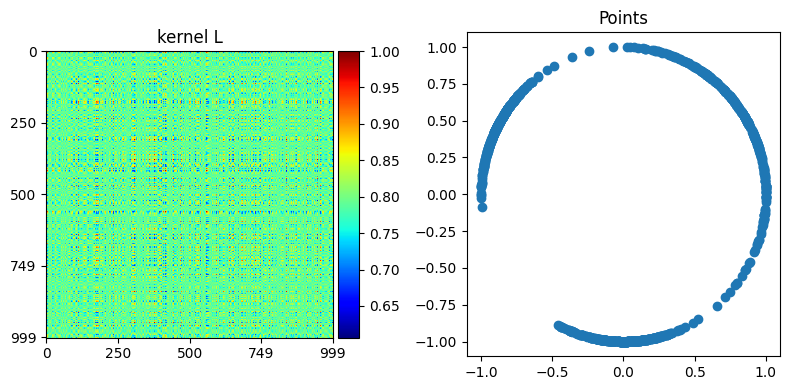

In [3]:
N, d = 1000, 2

dist = 'randsp'; kernel_type = 'vmf_gamma=0.5'
dist = 'blobsp'; kernel_type = 'vmf_gamma=0.5'

data = get_X(N, d, dist); X = data['X']
L = get_L(X, kernel_type)
print(L[:3,:3])

fig, axs = plt.subplots(1, 2, figsize=(8,4))
ax = axs[0]
plt_kernel_matrix_one(fig, ax, L, title='kernel L')
ax = axs[1]
ax.scatter(X[:,0], X[:,1])
ax.set_title('Points')
fig.tight_layout()

In [15]:
k = 20
Is = {}
for subset_type in ['random', 'dpp_sample', 'dppmap']:#  'dpp_exactk', 
    Is[subset_type] = get_subset(L, subset_type, k)

K (correlation) kernel computed via:
- eigendecomposition of L
- eig_K = eig_L/(1+eig_L)
- U diag(eig_K) U.T
2.4724571785347234e-11


/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/note_pruning_dpp.py:134: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[Y==y,0], X[Y==y,1], alpha=.3, cmap='Pastel1')


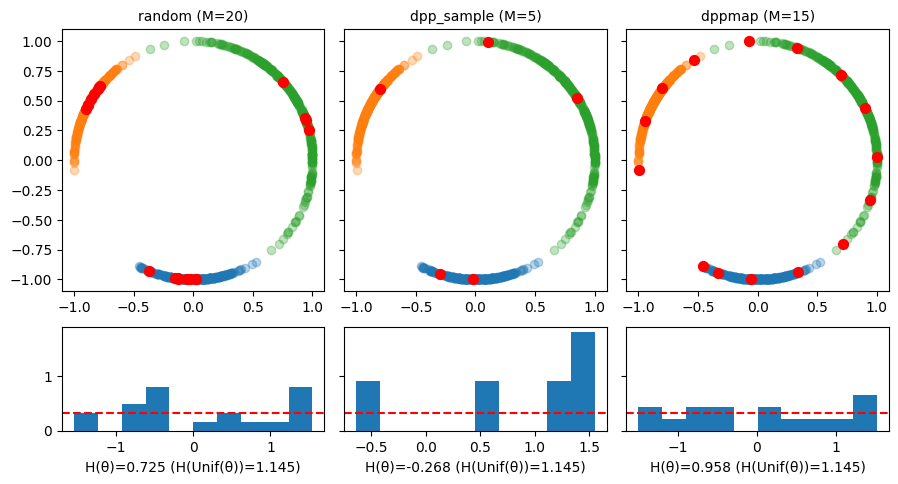

In [5]:
fig, axs = plt_subsets(Is, data)

## Effect of varying inner product kernel parameter on MAP re-turned set size

In [6]:
dist = 'randsp'; kernel_type_list = [f'vmf_gamma={gamma}' for gamma in [.1, 3, 10, 30]]
dist = 'blobsp'; kernel_type_list = [f'vmf_gamma={gamma}' for gamma in [.1, 3, 10, 30]]

N, d = 1000, 2
data = get_X(N, d, dist); X = data['X']

Is = {}
subset_type = 'dppmap'
for kernel_type in kernel_type_list:
    L = get_L(X, kernel_type)
    Is[f'{subset_type} (k={kernel_type})'] = get_subset(L, subset_type, len(L)) 

1.5241742279642107e-11
4.4554863024101975e-11
9.471730190442907e-11
2.4724571785347234e-11


/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/note_pruning_dpp.py:134: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[Y==y,0], X[Y==y,1], alpha=.3, cmap='Pastel1')


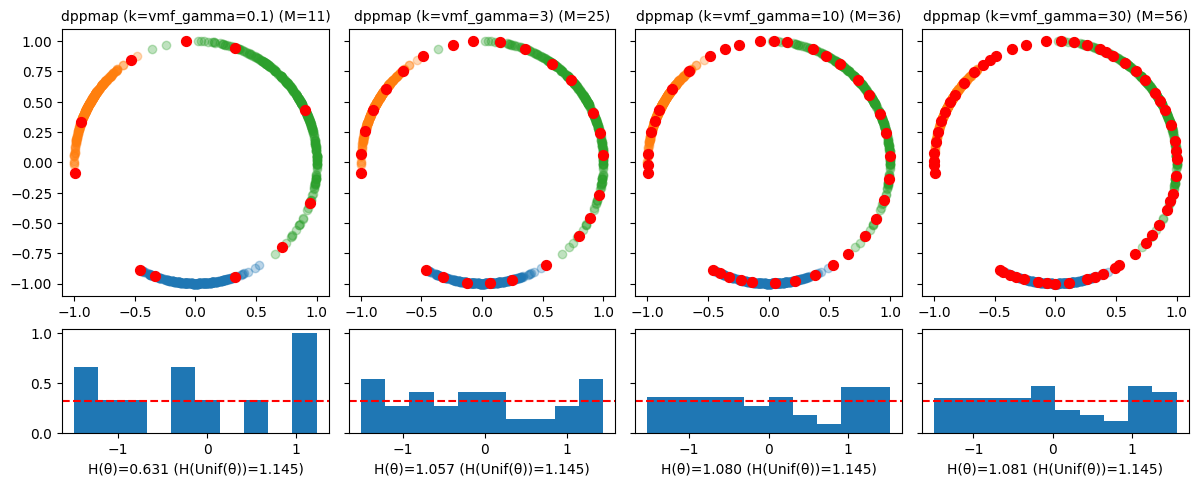

In [7]:
fig, axs = plt_subsets(Is, data)

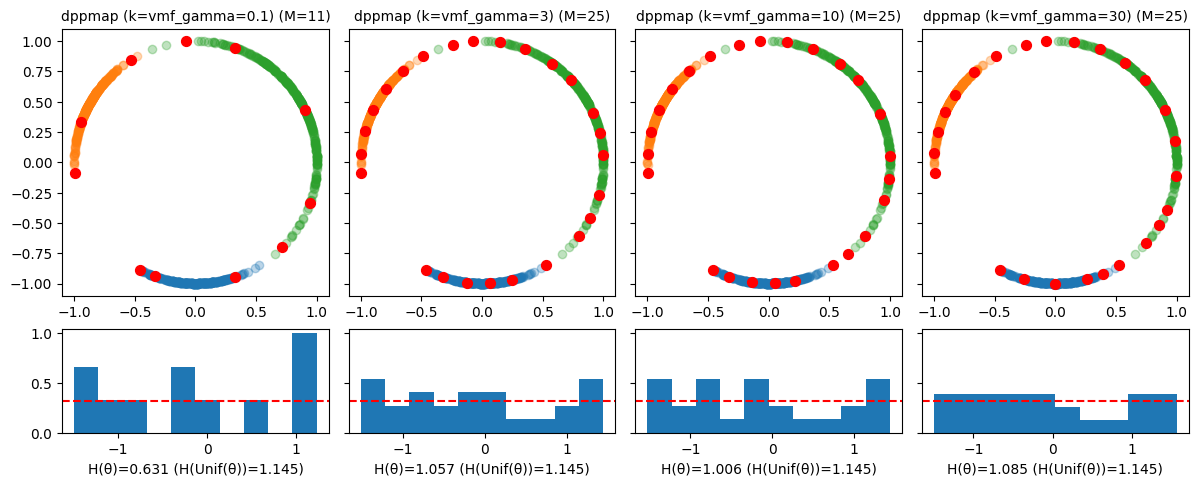

In [8]:
fig, axs = plt_subsets({k: v[:25] for k,v in Is.items()}, data)

## Effect of adding jitter to diagonal of kernel matrix on MAP results

In [9]:
dist = 'randsp'; kernel_type = 'vmf_gamma=1'
dist = 'blobsp'; kernel_type = 'vmf_gamma=1'

N, d = 1000, 2; 
data = get_X(N, d, dist); X = data['X']

Is = {}
Is['random'] = get_subset(L, 'random', k=50)

subset_type = 'dppmap'
for eps in [0, 1, 3]:
    L = get_L(X, kernel_type)
    L = L+np.eye(len(L))*eps
    Is[subset_type+f'(jitter={eps})'] = get_subset(L, subset_type, len(L))

3.839682734595444e-11
fast_map_dpp iterations =  100
fast_map_dpp iterations =  200
fast_map_dpp iterations =  300
fast_map_dpp iterations =  400
fast_map_dpp iterations =  500
fast_map_dpp iterations =  600
fast_map_dpp iterations =  700
fast_map_dpp iterations =  800
fast_map_dpp iterations =  900
fast_map_dpp iterations =  100
fast_map_dpp iterations =  200
fast_map_dpp iterations =  300
fast_map_dpp iterations =  400
fast_map_dpp iterations =  500
fast_map_dpp iterations =  600
fast_map_dpp iterations =  700
fast_map_dpp iterations =  800
fast_map_dpp iterations =  900


/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/note_pruning_dpp.py:134: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[Y==y,0], X[Y==y,1], alpha=.3, cmap='Pastel1')


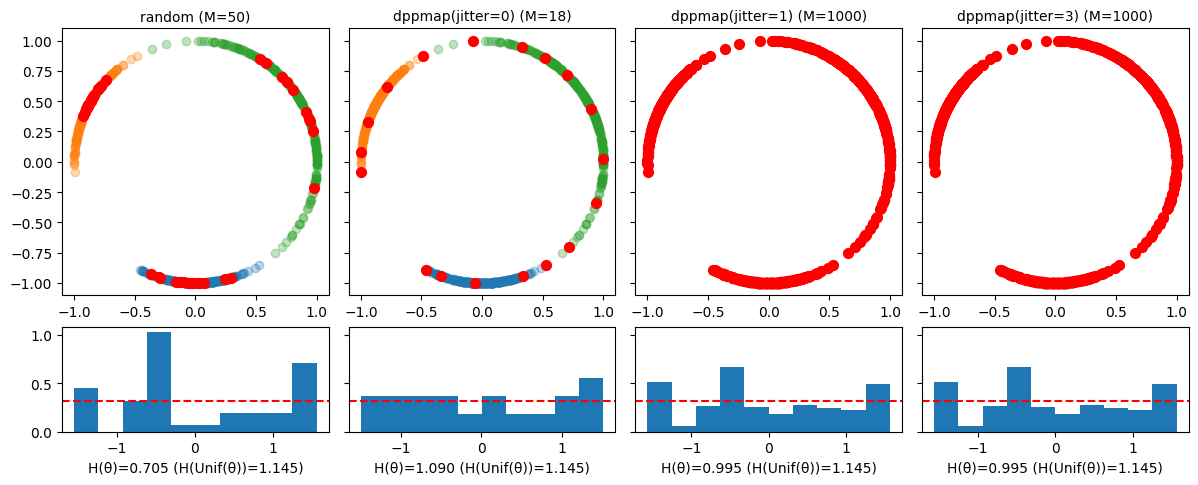

In [10]:
fig, axs = plt_subsets(Is, data)

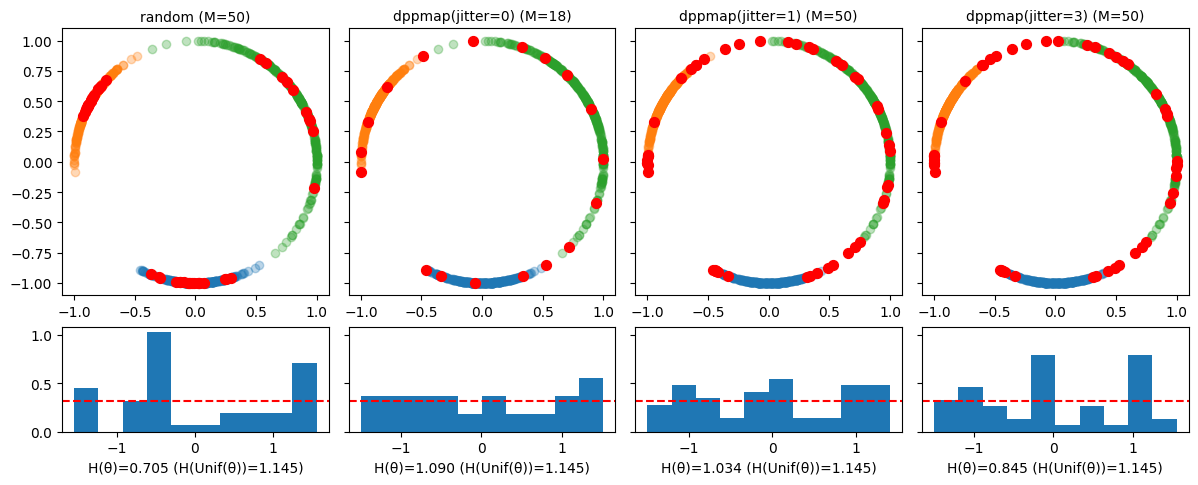

In [11]:
fig, axs = plt_subsets({k: v[:50] for k,v in Is.items()}, data)

## implement dppmap with block-diagonal kernel via ind. 

In [12]:
dist = 'randsp'; kernel_type_list = [f'vmf_gamma={gamma}' for gamma in [.1, 3, 10, 30]]
dist = 'blobsp'; kernel_type_list = [f'vmf_gamma={gamma}' for gamma in [.1, 3, 10, 30]]

N, d = 1000, 2
data = get_X(N, d, dist); X = data['X']; Y = data['Y'];


1.5241742279642107e-11
4.4554863024101975e-11
9.471730190442907e-11
2.4724571785347234e-11


/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/note_pruning_dpp.py:134: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[Y==y,0], X[Y==y,1], alpha=.3, cmap='Pastel1')


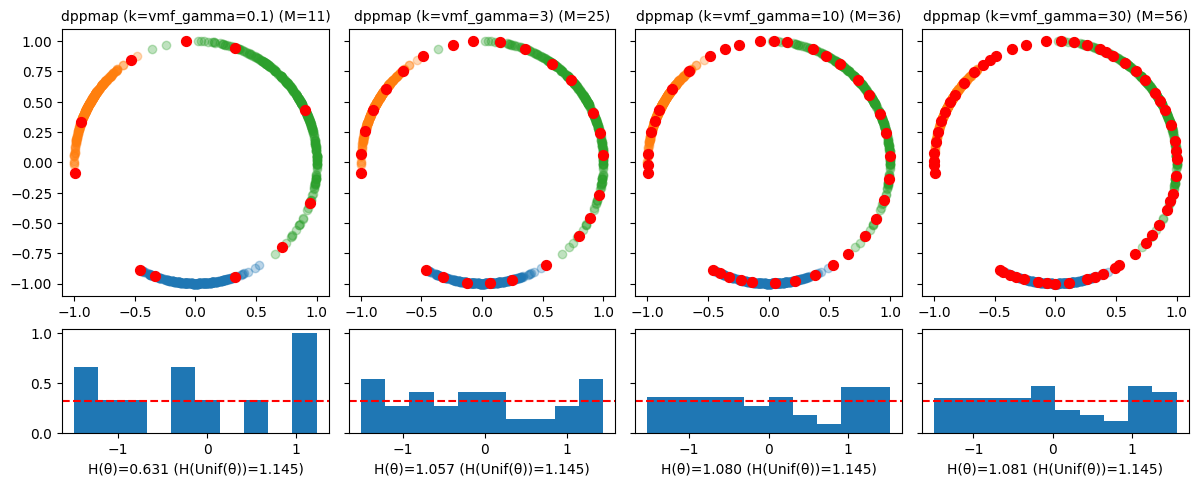

In [13]:
Is = {}
subset_type = 'dppmap'
for kernel_type in kernel_type_list:
    L = get_L(X, kernel_type)
    Is[f'{subset_type} (k={kernel_type})'] = get_subset(L, subset_type, len(L)) 
fig, axs = plt_subsets(Is, data)

8.352817791647739e-11
9.304879920691715e-12
5.273276223076526e-12
1.9758238957216696e-11
7.645093384522125e-13
3.86863457169003e-11
3.649195912968692e-11
1.4663753352682916e-11
9.71155735516633e-11
3.3242692210643e-11
5.530395944068711e-12
2.6311107514465522e-11


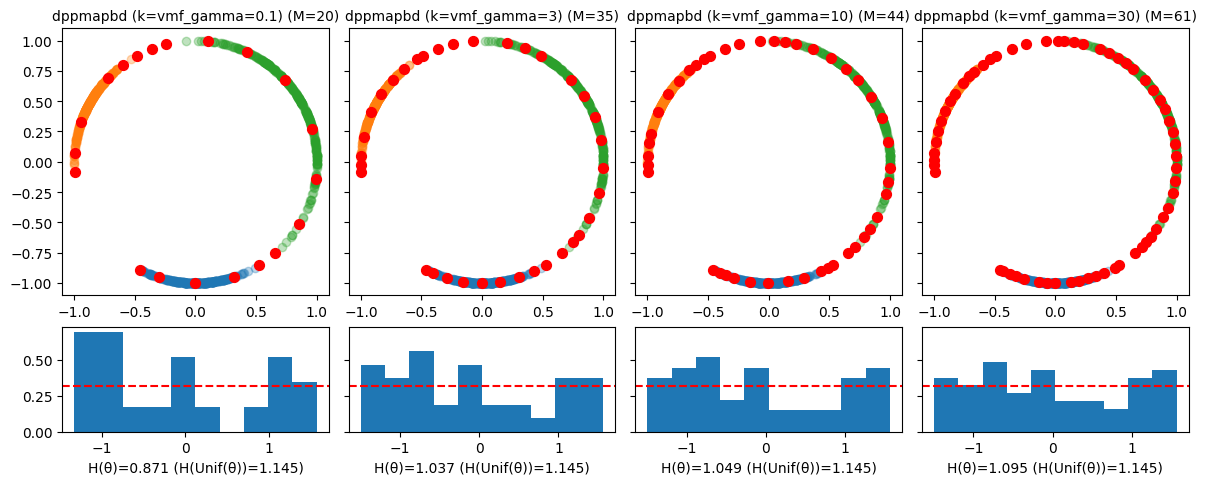

In [14]:
from note_pruning_dpp import dppmapbd

Is = {}
subset_type = 'dppmapbd'
for kernel_type in kernel_type_list:
    Is[f'{subset_type} (k={kernel_type})'] = dppmapbd(X, Y, kernel_type) 
fig, axs = plt_subsets(Is, data)

## implements dppmap 

## implements dppmap with block diagonal kernel in 1 run

## impl dppmap in torch 